# Exploring Exoplanet Formation and Evolution from Kepler Space Telescope Lightcurves

### Abstract: 

The transit method was used to identify three exoplanets orbiting an unknown host star, measured by the Kepler Space Telescope. These exoplanets had periods of $13.04 \pm 0.05$, $22.69 \pm 0.05$ and $31.97 \pm 0.05$ days. Therefore, their semi major axes were found to be $0.12 \pm 0.03$, $0.16 \pm 0.03$ and $0.20 \pm 0.03$ respectively and their masses were provided as $2.9 +2.9 -1.6$, $7.3 +0.8 -1.5$ and $8.8 +1.5 -2.1$ Earth Masses respectively. By comparing these exoplanets masses and semi major axes to the NASA exoplanet archive graphically, it was possible to determine that the most likely formation mechanism for all of them was core accretion. Gravitational interactions between exoplanets, both with the host star and each other, have significant effects on how the planetary orbits evolve, which can affect their habitability. In particular the eccentricity of the orbits can be altered, which was measured using the photoeccentric effect. The eccentricities were found as $0.74 \pm 0.04$, $0.26 \pm 0.02$ and $0.83 \pm 0.05$. In extreme cases, gravitational interactions can cause exoplanets to cross their Roche limits and be torn apart by tidal forces, so the Roche limits of the exoplanets were also determined and found to be $0.009 +0.003 -0.0002$, $0.008 +0.0002 -0.002$ and $0.008 +0.002 -0.003$AU. The tidal locking zone of this system was found to have an outer radius of $0.39 \pm 0.02$AU, so it is likely that all the exoplanets are tidally locked or have a resonant orbit, which further indicates that these exoplanets are unlikely to be habitable. The most likely sources of error in the values determined are transit timing variations and the effects of limb darkening.

#### Imports: 

In [14]:
import numpy as np #maths library
from astropy.io import fits #used to open fits files in which data are stored
import matplotlib.pyplot as plt #plotting
import matplotlib.patches as draw #drawing shapes on graphs
import glob #for fits files
import pandas as pd #data handling
from scipy.optimize import curve_fit #optimisation fitting
from scipy.signal import savgol_filter #import library for curve smoothing etc
from matplotlib.transforms import ScaledTranslation #for plotting shapes on log log graphs
from matplotlib.patches import Ellipse #for outlining regions on graphs
from scipy.stats import ks_2samp #statistical testing
import scipy.signal #for signal processing
from scipy.signal import lombscargle #generating periodograms

### 1. Introduction:

The first exoplanet orbiting a main sequence star was discovered by Mayor and Queloz (1995), though ‘exoplanet’ refers to any planet outside of the solar system. There are a variety of methods for detecting exoplanets, such as the radial velocity method which measures a potential host star’s 'Doppler wobble' around the common centre of mass of it and its exoplanet(s), or the direct imaging method which aims to discover exoplanets by observing them directly. In this report, the transit method is explored, the aim of which is to observe the periodic drop in stellar flux caused by the exoplanet passing in front of its host star and blocking some of its light.

A large part of the motivation for studying and discovering exoplanets is to search for life outside of our solar system, and the biology of early life forms. However, the study of exoplanets can also be used to look further back in history and investigate the formation of exoplanets and the evolution of their orbits. This report aims to determine the most likely formation mechanism for a number of exoplanets from their lightcurves, and explore how their orbits may have changed since formation.

There are two key mechanisms by which exoplanets can form: core accretion and direct gravitational collapse. Exoplanets forming by core accretion slowly accumulate their mass over time, as dust particles collide and coalesce, forming into increasingly massive rocks, and eventually planetesimals. These have a radius of around 10km, and combine to form the planetary core. This core continues to accumulate matter until a planet is formed, typically clearing a path in the disk as it does so. Exoplanets which form by direct collapse form much more similarly to their stellar hosts: an instability in the disk causes a section to collapse under its own gravity, forming a massive planet. These planets tend to have large radii and large semi major axes.

Today, the discovered exoplanet count stands at well over 5000. Many space telescopes have been launched with a key mission goal being to study exoplanets, such as Spitzer, Hubble, or the telescope used in this report: Kepler. The now retired Kepler Space Telescope was launched in 2009 with its only piece of equipment being a photometer, which continually monitored the flux of around 150,000 stars, aiming to discover exoplanets by the transit method. Here, Kepler Space Telescope data from an unknown host star is used.

Early in their formation, planets are expected to have a circular orbit as the gravitational force of their host star dominates their motion. There are a number of ways in which planetary orbits can be altered, including by disk migration, gravitational scattering, or in some cases, tidal migration. Interactions like these were key in the development of our arguably unusual solar system, classified as such by Mishra et al (2023), therefore the study of interactions between exoplanets can give an insight into the conditions that lead to the possibility for life elsewhere. 

Planetary migration can also lead to inner planets crossing their Roche limit, derived by Roche (1851), at which point the tidal force of their host star is greater than the planet's gravitational forces, and it is torn apart. Tidal forces can further be studied by considering the tidal locking region, at which point it is highly likely the exoplanet has entered a geosynchronous orbit. It will appear that the same side of the planet is always facing its host star, which can lead to the formation of ‘eyeball planets.' Tidal locking can mean that exoplanets with many properties conducive to life are most likely to be uninhabitable in reality, according to Barnes (2017). 

### 2. Results - Modelling of Kepler lightcurve


The process of reducing the data from its raw state will convert it to a state from which exoplanets and their properties can be determined. Applying the Lomb-Scargle algorithm, described by VanderPlas, Jacob T. (2018), to the reduced data will produce a periodogram, which is used to identify the dominant periods in the data sequence. Aliasing produces a periodic signal, so a secondary application of the Lomb-Scargle algorithm will remove these effects, leaving only the periods of exoplanet candidates as dominant peaks.

Text(0.1, -0.2, 'Figure 1. Reduced data from the Kepler Space Telescope. ')

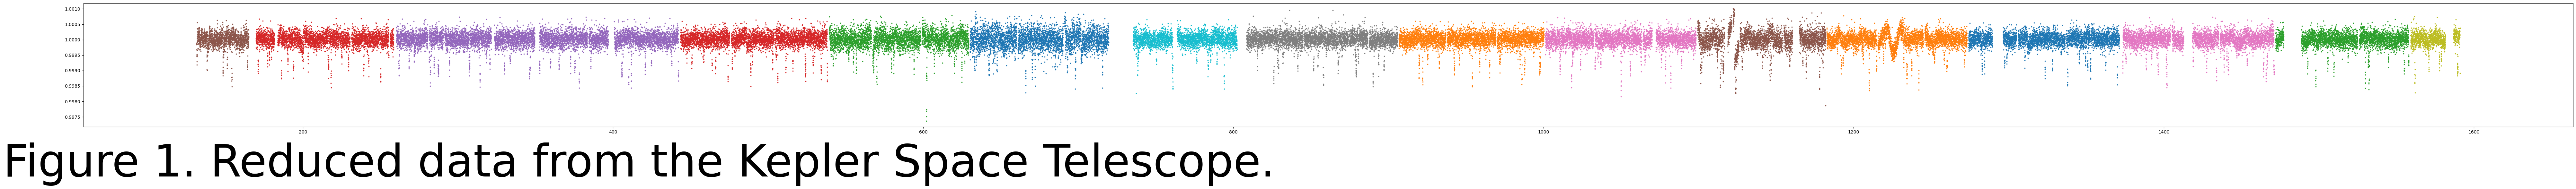

In [15]:
#reduce the data
fig = plt.figure(figsize = (100, 5)) #make graph extra long
#array setup
t = []
f = []
e = []

#read data in
for lcfile in glob.glob('Data/Objectlc/kplr*.fits'):
    with fits.open(lcfile) as tmp: #means file closes automatically at the end to avoid excessive memory use
        time = tmp[1].data['TIME'] #time is assigned to array
        flux = tmp[1].data['PDCSAP_FLUX'] #flux is assigned
        err_flux = tmp[1].data['PDCSAP_FLUX_ERR']

#normalise data
    time = time[~np.isnan(flux)] #drop nans
    flux = flux[~np.isnan(flux)] #drop nans
    err_flux = err_flux[~np.isnan(err_flux)]
    savgol = savgol_filter(flux, window_length=1001, polyorder = 3) #determine value needed for normalisation
    normalised_flux = flux / savgol #normalise flux
    normalised_flux_err = err_flux / savgol #normalise flux
    

#remove nonphysical outliers
    index = normalised_flux > 1 + 3*np.std(normalised_flux)
    final_time = time[~index]
    final_flux = normalised_flux[~index]
    final_flux_err = normalised_flux_err[~index]
    
    t.extend(final_time)
    f.extend(final_flux)
    e.extend(final_flux_err)

#plot :)
    plt.scatter(final_time, final_flux, ls='None', marker = 'o', s = 3)

txt = '''Figure 1. Reduced data from the Kepler Space Telescope. '''
fig.text(.1,-0.2,txt, fontsize = 100)

In [16]:
#determine the frequency ranges for lombscargle
print(t[1] - t[0])
print(t[-1]-t[0])

0.020433028395927977
840.9406094244041


In [17]:
#apply lombscargle to the data obtain a periodogram
freqs = np.linspace((1/841.),(1/0.02), 10000)
lomb = scipy.signal.lombscargle(t, f, freqs, precenter=True)

Text(0.1, 0.02, 'Figure 2. Periodogram up to period = 50 days, produced using the Lomb-Scargle algorithm. High peaks indicate dominant periods, and therefore exoplanet candidates.')

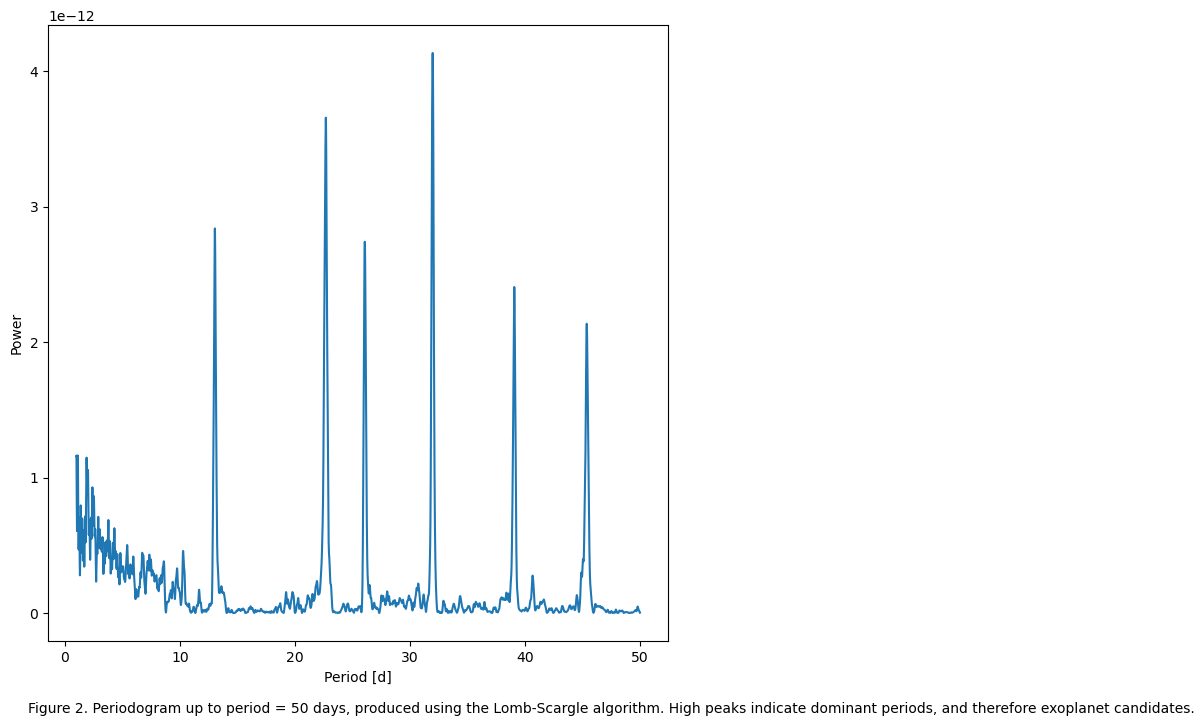

In [18]:
#apply lombscargle again to deal with aliasing effects
period = np.linspace(1,50, 10000)
lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)
fig = plt.figure(figsize = (8, 8))
plt.plot(period, lomb2)
plt.xlabel('Period [d]')
plt.ylabel('Power')
txt = '''Figure 2. Periodogram up to period = 50 days, produced using the Lomb-Scargle algorithm. High peaks indicate dominant periods, and therefore exoplanet candidates.'''
fig.text(.1,.02,txt)

High peaks are indicative of exoplanets, so from this there are 6 exoplanet candidates:

$T_1 = 13.04240848169634$

$T_2 = 22.69126912691269$

$T_3 = 26.078039019509756$

$T_4 = 31.96996996996997$

$T_5 = 39.068068068068065$

$T_6 = 45.36536536536536$

$T_3$ and $T_5$ are repeats of $T_1$, and $T_6$ is a repeat of $T_2$, leaving:

$T_1 = 13.04240848169634$

$T_2 = 22.69126912691269$

$T_3 = 31.96996996996997$

as possible candidates. Folding this data over the period will enable a visual check to be performed, assessing whether an exoplanet is present. Sorting the data will produce a tidier graph once folded.

In [19]:
#define a function to fold the lightcurve
#provided by Dr P. Schady
def fold_lightcurve(time, flux, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    flux: input flux
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded flux, folded error
    """
    #Create a pandats dataframe from the 
    data = pd.DataFrame({'time': time, 'flux': flux, 'error': error})
    
    #create the phase 
    data['phase'] = data.apply(lambda x: ((x.time/ period) - np.floor(x.time / period)), axis=1)
    
    #Creates the out phase, flux and error
    phase_long = np.concatenate((data['phase'], data['phase'] + 1.0, data['phase'] + 2.0))
    flux_long = np.concatenate((flux, flux, flux))
    err_long = np.concatenate((error, error, error))
    
    return(phase_long, flux_long, err_long)

In [20]:
p1, p1_flux, p1_error = fold_lightcurve(t, f, e, 13.04240848169634)
p2, p2_flux, p2_error = fold_lightcurve(t, f, e, 22.69126912691269)
p3, p3_flux, p3_error = fold_lightcurve(t, f, e, 31.96996996996997)

In [21]:
sort_p = np.argsort(p1)
p1 = p1[sort_p]
p1_flux = p1_flux[sort_p]
p1_error = p1_error[sort_p]
sort_p = np.argsort(p2)
p2 = p2[sort_p]
p2_flux = p2_flux[sort_p]
p2_error = p2_error[sort_p]
sort_p = np.argsort(p3)
p3 = p3[sort_p]
p3_flux = p3_flux[sort_p]
p3_error = p3_error[sort_p]

Lightcurves can be modelled mathematically with a variety of forms such as by Carter et al (2008), but here we define a function of form

$a \tanh(\frac{1}{b} \times (x + c))^2 +d$

to model the transit, where $a$ represents the drop in flux due to the transiting exoplanet, $b$ represents the duration of the transit, $c$ represents the phase location of the transit, and $d$ represents the baseline flux outside of the transit.

In [22]:
#define function to model lightcurve
def transitfunc (x, fluxDrop, width, centre, baseFlux):
    return (fluxDrop*(np.tanh((1/width)*(x + centre))**2) + baseFlux)

Text(0.1, -0.02, 'Figure 3. Lightcurve folded with period = 13.04240848169634 days. The exoplanet transit is visible where \n the flux drops. The grey points represent the Kepler data, and the red line shows the model of this curve.')

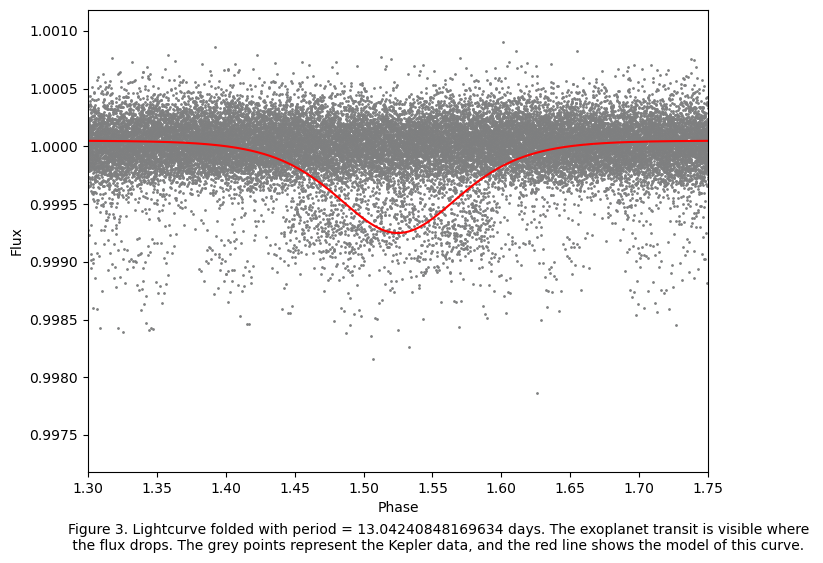

In [23]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(p1, p1_flux, marker='o', markersize = 1, ls='None', label='_nolegend_', mec='Grey')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.errorbar(p1, transitfunc(p1, 0.0008, 0.06, -1.525, 0.99925), linestyle = '-', color = 'r', marker = 'None', zorder = 2)
plt.xlim(1.3, 1.75)
txt = '''Figure 3. Lightcurve folded with period = 13.04240848169634 days. The exoplanet transit is visible where \n the flux drops. The grey points represent the Kepler data, and the red line shows the model of this curve.'''
fig.text(.1,-.02,txt)

Text(0.1, -0.02, 'Figure 4. Lightcurve folded with period = 22.69126912691269 days. The grey points represent the \nKepler data which have a clear flux drop and gap showing the transit, and the red line shows the model of this curve.')

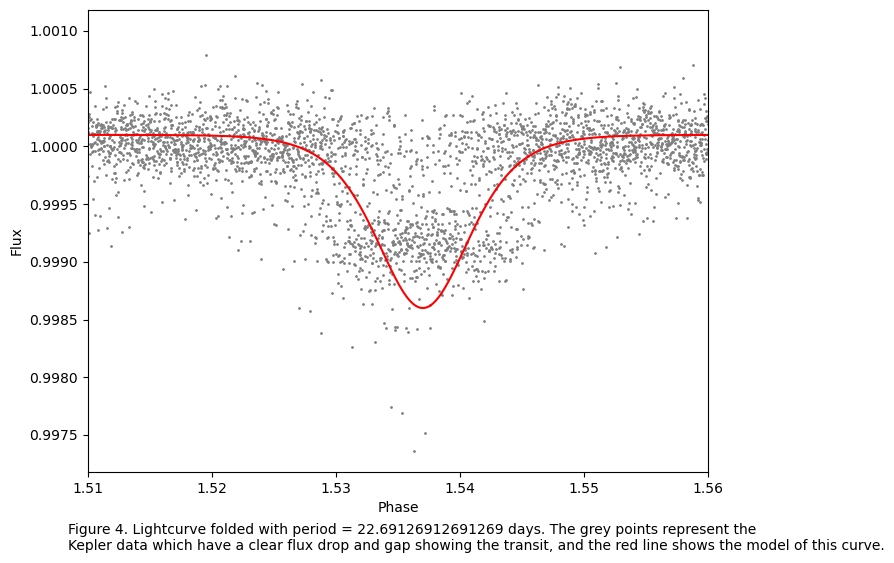

In [24]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(p2, p2_flux, marker='o', markersize = 1, ls='None', label='_nolegend_', mec='Grey')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.errorbar(p2, transitfunc(p2, 0.0015, 0.005, -1.537, 0.9986), linestyle = '-', color = 'r', marker = 'None', zorder = 2)
plt.xlim(1.51, 1.56)
txt = '''Figure 4. Lightcurve folded with period = 22.69126912691269 days. The grey points represent the \nKepler data which have a clear flux drop and gap showing the transit, and the red line shows the model of this curve.'''
fig.text(.1,-.02,txt)

Text(0.1, -0.02, 'Figure 5. Lightcurve folded with period = 31.96996996996997 days. The grey points represent the \nKepler data which have a flux drop where the exoplanet transitted, and the red line shows the model of this curve.')

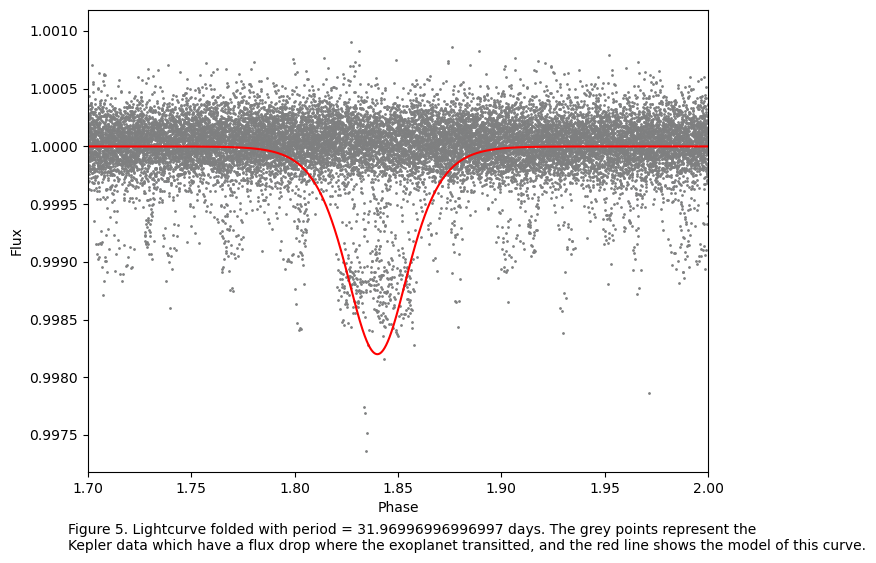

In [25]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(p3, p3_flux, marker ='o', markersize = 1, ls='None', label='_nolegend_', mec='Grey')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.errorbar(p3, transitfunc(p3, 0.0018, 0.02, -1.84, 0.9982), linestyle = '-', color = 'r', marker = 'None', zorder = 2)
plt.xlim(1.7,2)
txt = '''Figure 5. Lightcurve folded with period = 31.96996996996997 days. The grey points represent the \nKepler data which have a flux drop where the exoplanet transitted, and the red line shows the model of this curve.'''
fig.text(.1,-.02,txt)

$\chi ^2$ and a residuals plot are used to assess the fit of the model compared to the lightcurve data.

In [26]:
def chi_squared(x, y, err, a, b, c, d):
    return ((y - transitfunc(x,a,b,c,d))**2)/err**2

In [27]:
p1chi = chi_squared(p1, p1_flux, p1_error,  0.0008, 0.06, -1.525, 0.99925)
p1chisq = np.sum(p1chi)/len(p1)
print('Exoplanet 1: ', p1chisq)
p2chi = chi_squared(p2, p2_flux, p2_error,  0.0015, 0.005, -1.537, 0.9986)
p2chisq = np.sum(p2chi)/len(p2)
print('Exoplanet 2: ', p2chisq)
p3chi = chi_squared(p3, p3_flux, p3_error,  0.0018, 0.02, -1.84, 0.9982)
p3chisq = np.sum(p3chi)/len(p3)
print('Exoplanet 3: ', p3chisq)

Exoplanet 1:  3.0288408938365
Exoplanet 2:  2.842954447441418
Exoplanet 3:  3.409509298836796


Text(0.1, -0.02, 'Figure 6. Residuals are plotted against phase for the exoplanet with period ~= 13.04 days, \ngiving a visual representation of the quality of the fit of the model to the data.')

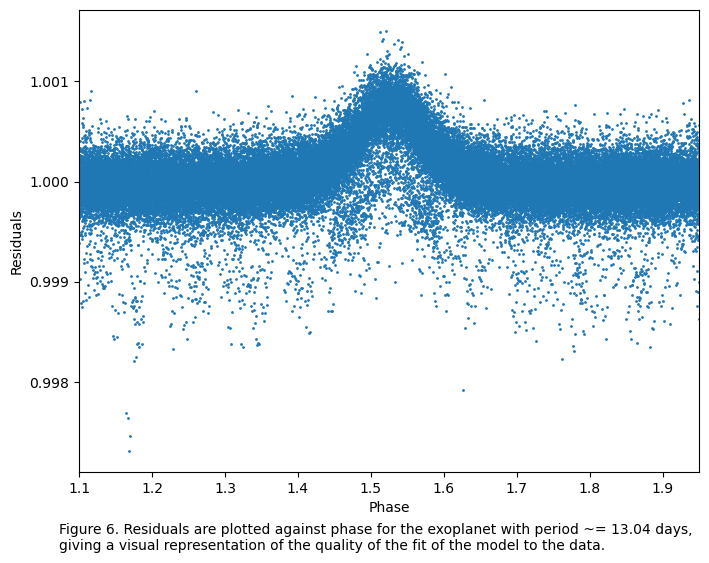

In [28]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(p1,p1_flux/(transitfunc(p1, 0.0008, 0.06, -1.525, 0.99925)),  marker = 'o', markersize = 1, ls = 'None')
plt.xlabel('Phase')
plt.ylabel('Residuals')
plt.xlim(1.1,1.95)
txt = '''Figure 6. Residuals are plotted against phase for the exoplanet with period ~= 13.04 days, \ngiving a visual representation of the quality of the fit of the model to the data.'''
fig.text(.1,-.02,txt)

Text(0.1, -0.02, 'Figure 7. Residuals are plotted against phase for the exoplanet with period ~= 22.69 days, \ngiving a visual representation of the quality of the fit of the model to the data.')

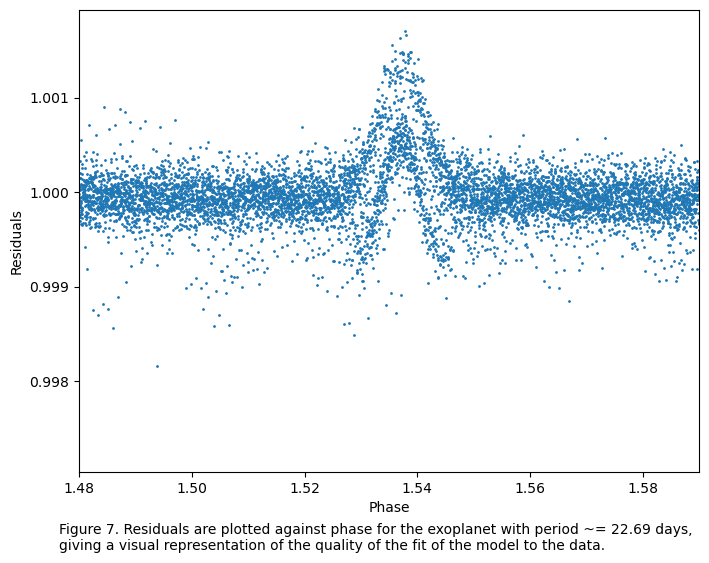

In [29]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(p2,p2_flux/(transitfunc(p2, 0.0015, 0.005, -1.537, 0.9986)), marker = 'o', markersize = 1, ls = 'None')
plt.xlabel('Phase')
plt.ylabel('Residuals')
plt.xlim(1.48, 1.59)
txt = '''Figure 7. Residuals are plotted against phase for the exoplanet with period ~= 22.69 days, \ngiving a visual representation of the quality of the fit of the model to the data.'''
fig.text(.1,-.02,txt)

Text(0.1, -0.02, 'Figure 8. Residuals are plotted against phase for the exoplanet with period ~= 31.97 days, \ngiving a visual representation of the quality of the fit of the model to the data.')

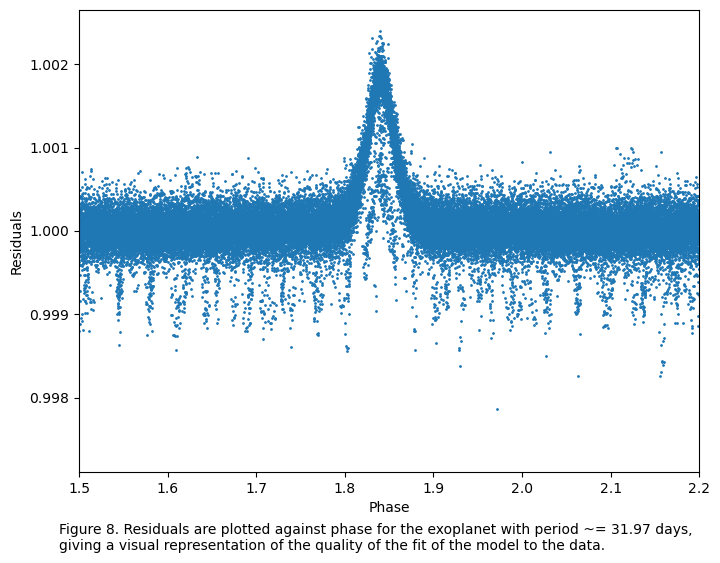

In [30]:
fig = plt.figure(figsize = (8, 6))
plt.errorbar(p3, p3_flux/(transitfunc(p3, 0.0018, 0.02, -1.84, 0.9982)), marker = 'o', markersize = 1, ls = 'None')
plt.xlabel('Phase')
plt.ylabel('Residuals')
plt.xlim(1.5, 2.2)
txt = '''Figure 8. Residuals are plotted against phase for the exoplanet with period ~= 31.97 days, \ngiving a visual representation of the quality of the fit of the model to the data.'''
fig.text(.1,-.02,txt)

Three exoplanets have been found orbiting this star. 

The transits for exoplanet 1, 2 and 3 can be described by:

$0.0008 \tanh(\frac{1}{0.06} \dot (x - 1.525))^2 + 0.99925$,

$0.0015 \tanh(\frac{1}{0.005} \dot (x - 1.537))^2 + 0.9986$,

and $0.0018 \tanh(\frac{1}{0.02} \dot (x - 1.84))^2 + 0.9982$ respectively.

From the values of $\chi ^2$ and the residual plots, it can be concluded that the fits are reasonable, so it is possible to determine properties of the exoplanets from these models.

In [31]:
#set up dataframe of exoplanet parameters
df = pd.DataFrame({
    "Planet Name": ["Exoplanet 1", "Exoplanet 2", "Exoplanet 3"],
    "Planet Mass / Earth masses": ["2.9 +2.9 -1.6", "7.3 +0.8 -1.5", "8.8 +1.5 -2.1"],
    "Period / days": ['13.04 $\pm$ 0.05', '22.69 $\pm$ 0.05', '31.97 $\pm$ 0.05'], 
    "$\chi ^2$": [3.03, 2.84, 3.41],
  })

#set caption
caption = "Table 1: Properties of the three exoplanets: Mass in Earth masses, Period in days and $\chi ^2$ from the transit model"

#define function for tidiness
def make_pretty(styler):
    styler.set_caption(caption)
    styler.format(precision=2, thousands=",", decimal=".") ## this determines the formatting
    return styler

#display table
df.style.pipe(make_pretty)

,Planet Name,Planet Mass / Earth masses,Period / days,$\chi ^2$
0,Exoplanet 1,2.9 +2.9 -1.6,13.04 $\pm$ 0.05,3.03
1,Exoplanet 2,7.3 +0.8 -1.5,22.69 $\pm$ 0.05,2.84
2,Exoplanet 3,8.8 +1.5 -2.1,31.97 $\pm$ 0.05,3.41


The semi major axis can be determined with Kepler's Third Law, and can be used to investigate the formation mechanism. This law gives the relationship between period $T$ and semi major axis $a$ as $T^2 = a^3$.

Density can simply be determined as $\rho = \frac{M}{V}$ where $\rho$ represents density in gcm$^{-3}$, $M$ represents mass in grams and $V$ represents volume in cm$^3$. To obtain this, the radii of the exoplanets is required, which can be found using

$\frac{\Delta F}{F} = \frac{R_p^2}{R_*^2}$ where $\Delta F$ represents the flux drop during transit, $F$ represents the original flux, $R_p$ represents the exoplanet's radius, and $R_*$ represents the host star's radius, having value $R_* = 1.046R_\odot$. This equation can be rearranged to reach
$R_p = 

In [49]:
#add exoplanet parameters
df['Semi Major Axis / AU'] = ['0.12 $\pm$ 0.03', '0.16 $\pm$ 0.03', '0.20 $\pm$ 0.03']
df['Radius / m'] = ['(23 $\pm$ 1) x 10$^6$', '(28 $\pm$ 1) x 10$^6$', '(30 $\pm$ 1) x 10$^6$']
df['Density / gcm$^{-3}$'] = ['0.68 +0.68 -0.38', '0.93 +0.15 -0.22', '0.98 +0.19 -0.25']

#update caption
caption = "Table 2: Properties of the three exoplanets: Mass in Earth masses, Period in days, $\chi ^2$ from the transit model, and radius and density as calculated"

#display table
df.style.pipe(make_pretty)

,Planet Name,Planet Mass / Earth masses,Period / days,$\chi ^2$,Semi Major Axis / AU,Radius / m,Density / gcm$^{-3}$,Eccentricity,Roche Limit / AU
0,Exoplanet 1,2.9 +2.9 -1.6,13.04 $\pm$ 0.05,3.03,0.12 $\pm$ 0.03,(23 $\pm$ 1) x 10$^6$,0.68 +0.68 -0.38,0.74 $\pm$ 0.04,0.009 +0.003 -0.0002
1,Exoplanet 2,7.3 +0.8 -1.5,22.69 $\pm$ 0.05,2.84,0.16 $\pm$ 0.03,(28 $\pm$ 1) x 10$^6$,0.93 +0.15 -0.22,0.26 $\pm$ 0.02,0.008 +0.0002 -0.002
2,Exoplanet 3,8.8 +1.5 -2.1,31.97 $\pm$ 0.05,3.41,0.20 $\pm$ 0.03,(30 $\pm$ 1) x 10$^6$,0.98 +0.19 -0.25,0.83 $\pm$ 0.05,0.008 +0.002 -0.003


To explore the orbital evolution, properties such as the tidal lock zone radius and Roche limit are needed, as well as the eccentricity. Eccentricity cannot be easily determined from exoplanet lightcurves, but it is possible using the photoeccentric effect in the manner described by Eylen and Albrecht (2015) to obtain

$e = \sqrt{\left(1 - \frac{\rho_*}{\rho_{*, transit}}\right)^{2/3} }$

where $e$ is the eccentricity, $\rho_*$ is the density of the host star and

$\rho_{*, transit} = \left( \frac{3 \pi}{GT^2}\right) \left(\frac{a}{R_*}\right) ^3$.

In [33]:
#define function for transit density of star
def pstart(P, a, Rstar):
    br1 = ((3*np.pi)/(6.67*10e-8 * P**2))
    br2 = (a/Rstar)**3
    pstartr = br1 * br2
    return pstartr

In [34]:
#define function for eccentricity
def calculate_e(pstar, P, a, Rstar):
    esqd = np.abs(1-((pstar)/pstart(P, a, Rstar)))
    esq = esqd**(2/3)
    e = np.sqrt(np.abs(esq))
    return e

In [35]:
#calculate and print eccentricities
e1 = calculate_e(1.41, 13.04, 0.032, 1.046)
e2 = calculate_e(1.41, 22.6, 0.039, 1.046)
e3 = calculate_e(1.41, 32, 0.042, 1.046)
print(e1, e2, e3)

0.7413118801161831 0.2555385891764398 0.8331943114884313


The radius of the tidal locking zone can be calculated with

$a_{TL} = 0.3t^{\frac{1}{6}} M^{\frac{1}{3}}$,

as derived by Ballesteros et al (2019). The temperature of the star, 5657K, indicates it is of similar age to the sun so $t = 4.6$GYr. The mass of the host star was provided as $1M \odot$, therefore $a_{TL} = 0.39 \pm 0.02$AU.

Roche limit is calculated as

$d_R = R_* \left(\frac{2 \rho_*}{\rho_p}\right)^{\frac{1}{3}}$

where $\rho_p$ represents the density of the orbiting exoplanet.

In [36]:
#add values to dataframe
df['Eccentricity'] = ['0.74 $\pm$ 0.04', '0.26 $\pm$ 0.02', '0.83 $\pm$ 0.05']
df['Roche Limit / AU'] = ['0.009 +0.003 -0.0002', '0.008 +0.0002 -0.002', '0.008 +0.002 -0.003']

#update caption
caption = "Table 3: Properties of the three exoplanets: Mass in Earth masses, Period in days, $\chi ^2$ from the transit model, and radius and density as calculated, and orbital properties: eccentricity and Roche limit"
    
#display table
df.style.pipe(make_pretty)

,Planet Name,Planet Mass / Earth masses,Period / days,$\chi ^2$,Semi Major Axis / AU,Radius / m,Density / gcm$^{-3}$,Eccentricity,Roche Limit / AU
0,Exoplanet 1,2.9 +2.9 -1.6,13.04 $\pm$ 0.05,3.03,0.12 $\pm$ 0.03,(23 $\pm$ 1) x 10$^6$,0.68 +0.68 -0.38,0.74 $\pm$ 0.04,0.009 +0.003 -0.0002
1,Exoplanet 2,7.3 +0.8 -1.5,22.69 $\pm$ 0.05,2.84,0.16 $\pm$ 0.03,(28 $\pm$ 1) x 10$^6$,0.93 +0.15 -0.22,0.26 $\pm$ 0.02,0.008 +0.0002 -0.002
2,Exoplanet 3,8.8 +1.5 -2.1,31.97 $\pm$ 0.05,3.41,0.20 $\pm$ 0.03,(30 $\pm$ 1) x 10$^6$,0.98 +0.19 -0.25,0.83 $\pm$ 0.05,0.008 +0.002 -0.003


### 3. Discussion

#### 3.1. Determining Formation Mechanism by Comparison to NASA's Exoplanet Archive

In [38]:
#read data from NASA exoplanet archive
exoarchive_df = pd.read_csv('Data/exoplanet_data.csv', engine = 'python')

In [39]:
#create secondary version of dataframe which only has exoplanets discovered by the transit method
transit_exoplanets_df = exoarchive_df.loc[(exoarchive_df.discoverymethod == 'Transit')]

Statistical testing can be performed to compare the parameter values for the exoplanets found to those of the exoplanet archive.  This comparison is done only with exoplanets discovered by the transit method.

In this case, the Kolmogorov–Smirnov test is used, as explained in the Encyclopedia of Mathematics (2001). We aim to determine if the sample of exoplanets found is consistent with arising from the parent population: the NASA exoplanet archive. Arrays of key parameters for these exoplanets- period, semi major axis and mass- are set up, and the Kolmogorov-Smirnov test is applied for each case.

In [40]:
#arrays for exoplanet period, semi major axis and mass
exo_period = [13.04, 22.690959, 31.97]
exo_sma = [ ((13.04/365)**2)**(1/3), ((22.69/365)**2)**(1/3), ((31.97/365)**2)**(1/3) ]
exo_mass = [2.9, 7.3, 8.8]

In [41]:
#KS test for semi major axis
D, P = ks_2samp(exo_sma, transit_exoplanets_df.pl_orbsmax)
print('\033[1m' + "The probability that D=%.2f given the null hypothesis is %.1f %% (i.e. the null hypothesis cannot be rejected)" % (D,P*100) + '\033[0m')

The probability that D=0.58 given the null hypothesis is 18.0 % (i.e. the null hypothesis cannot be rejected)


In [42]:
#KS test for period
D, P = ks_2samp(exo_period, transit_exoplanets_df.pl_orbper)
print('\033[1m' + "The probability that D=%.2f given the null hypothesis is %.1f %% (i.e. the null hypothesis cannot be rejected)" % (D,P*100) + '\033[0m')

The probability that D=0.55 given the null hypothesis is 23.2 % (i.e. the null hypothesis cannot be rejected)


In [43]:
#KS test for mass
D, P = ks_2samp(exo_mass, exoarchive_df.pl_bmasse)
print('\033[1m' + "The probability that D=%.2f given the null hypothesis is %.1f %% (i.e. the null hypothesis cannot be rejected)" % (D,P*100) + '\033[0m')

The probability that D=0.97 given the null hypothesis is 0.0 % (i.e. the null hypothesis cannot be rejected)


Here, the large value of $D$ and low probability $p$ that this value arose by chance indicates that the two samples are consistent with each other: it is likely that the exoplanets found here arise from the parent sample- the NASA exoplanet archive.

The formation mechanism of exoplanets can be deduced most simply from the region of the mass-semi major axis diagram that they fall into. This diagram can be classified into three key regions, described by Hasegawa and Pudwritz (2013): the Hot Jupiter region, the Core Accretion region and the Gravitational Instability/Direct Gravitational Collapse region.

Hot Jupiters are gas giants with small semi major axes, orbiting close to their host stars. This region is of particular interest as these exoplanets are generally thought to only be possible by inwards migration, such as in D'Angelo (2010)'s description. The remaining two regions contain exoplanets formed by either core accretion or direct gravitational collapse. 


A graph of this description is made with all the exoplanets in the NASA exoplanet archive, as well as the three exoplanets identified in this report. As described, the location of the three discovered exoplanets on this diagram will be indicative of their formation mechanism.

In [44]:
#set up arrays to hold assymmetric mass error values
exo1_err = np.empty((2,1))
exo1_err[0] = 1.6
exo1_err[1] = 2.9
exo2_err = np.empty((2,1))
exo2_err[0] = 1.5
exo2_err[1] = 0.8
exo3_err = np.empty((2,1))
exo3_err[0] = 2.1
exo3_err[1] = 1.5

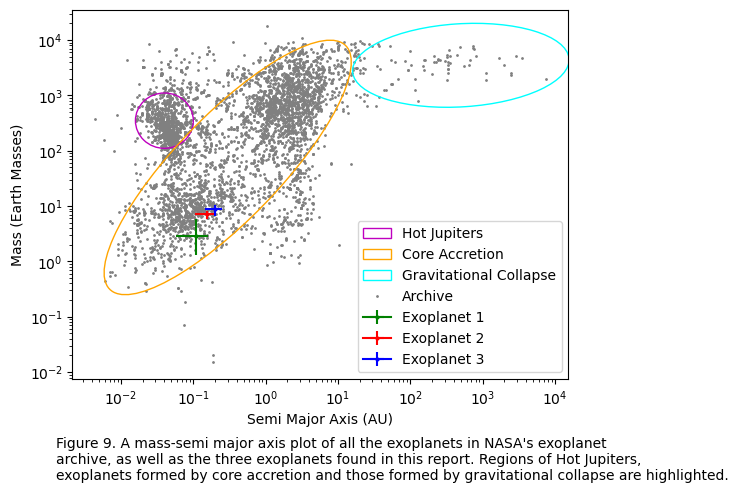

In [45]:
#plot mass-semi major axis graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(exoarchive_df.pl_orbsmax, exoarchive_df.pl_bmasse, marker = 'o', markersize = 1, ls = 'None', color = 'grey', label = 'Archive')
ax.errorbar(((13.04/365)**2)**(1/3), 2.9, xerr = 0.05, yerr = exo1_err, marker = 'o', color = 'green', markersize = 2, label = 'Exoplanet 1', zorder = 4)
ax.errorbar(((22.69/365)**2)**(1/3), 7.3, xerr = 0.05, yerr = exo2_err, marker = 'o', color = 'r', markersize = 2, label = 'Exoplanet 2', zorder = 4)
ax.errorbar(((31.97/365)**2)**(1/3), 8.8, xerr = 0.05, yerr = exo3_err, marker = 'o', color = 'blue', markersize = 2, label = 'Exoplanet 3', zorder = 4)
#label axes, set scales
plt.xlabel('Semi Major Axis (AU)')
plt.ylabel('Mass (Earth Masses)')
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)

#add ellipses to represent the three key regimes of formation
# Ellipse centre coordinates
x, y =  0.04, 350
# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
# Create the ellipse centred on the origin, apply the composite tform
ax.add_patch(Ellipse(xy=(0, 0), width=0.8, height=1, color="m", fill=False, lw=1, zorder=5, transform=ell_tform, label = 'Hot Jupiters'))
x, y = 0.3, 50
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
# Create the ellipse centred on the origin, apply the composite tform
ax.add_patch(Ellipse(xy=(0, 0), width=1.6, height=5.5, color="orange", fill=False, lw=1, zorder=5, angle = 145, transform=ell_tform, label = 'Core Accretion'))
x, y = 500, 3500
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
# Create the ellipse centred on the origin, apply the composite tform
ax.add_patch(Ellipse(xy=(0, 0), width=1.5, height=3, color="cyan", fill=False, lw=1, zorder=5, angle = 95, transform=ell_tform, label = 'Gravitational Collapse'))

txt = '''Figure 9. A mass-semi major axis plot of all the exoplanets in NASA's exoplanet \narchive, as well as the three exoplanets found in this report. Regions of Hot Jupiters, \nexoplanets formed by core accretion and those formed by gravitational collapse are highlighted.'''
fig.text(.1,-.1,txt)

ax.legend()

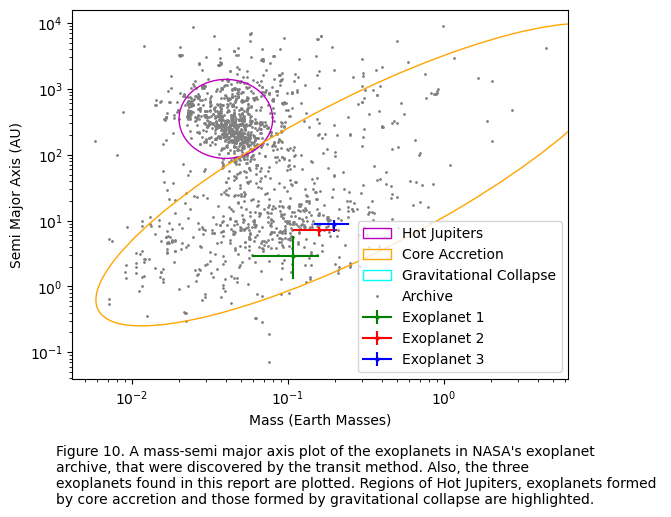

In [46]:
#plot mass-semi major axis graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(transit_exoplanets_df.pl_orbsmax, transit_exoplanets_df.pl_bmasse, marker = 'o', markersize = 1, label = 'Archive', ls = 'None', color = 'grey')
ax.errorbar(((13.04/365)**2)**(1/3), 2.9, xerr = 0.05, yerr = exo1_err, marker = 'o', color = 'green', markersize = 2, label = 'Exoplanet 1', zorder = 4)
ax.errorbar(((22.69/365)**2)**(1/3), 7.3, xerr = 0.05, yerr = exo2_err, marker = 'o', color = 'r', markersize = 2, label = 'Exoplanet 2', zorder = 4)
ax.errorbar(((31.97/365)**2)**(1/3), 8.8, xerr = 0.05, yerr = exo3_err, marker = 'o', color = 'blue', markersize = 2, label = 'Exoplanet 3', zorder = 4)
#set axis labels and scales
plt.xlabel('Mass (Earth Masses)')
plt.ylabel('Semi Major Axis (AU)')
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)

#add ellipses to represent the three key regimes of formation
# Ellipse centre coordinates
x, y = 0.04, 350
# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
# Create the ellipse centred on the origin, apply the composite tform
ax.add_patch(Ellipse(xy=(0, 0), width=0.6, height=1.2, color="m", fill=False, lw=1, zorder=5, transform=ell_tform, label = 'Hot Jupiters'))
x, y = 0.3, 50
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
# Create the ellipse centred on the origin, apply the composite tform
ax.add_patch(Ellipse(xy=(0, 0), width=1.6, height=5.5, color="orange", fill=False, lw=1, zorder=5, angle = 145, transform=ell_tform, label = 'Core Accretion'))
x, y = 500, 3500
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
# Create the ellipse centred on the origin, apply the composite tform
ax.add_patch(Ellipse(xy=(0, 0), width=1.5, height=3, color="cyan", fill=False, lw=1, zorder=5, angle = 95, transform=ell_tform, label = 'Gravitational Collapse'))

txt = '''Figure 10. A mass-semi major axis plot of the exoplanets in NASA's exoplanet \narchive, that were discovered by the transit method. Also, the three \nexoplanets found in this report are plotted. Regions of Hot Jupiters, exoplanets formed \nby core accretion and those formed by gravitational collapse are highlighted.'''
fig.text(.1,-.15,txt)

ax.legend()

This plot is repeated after reducing the exoplanet archive down to planets discovered only by the transit method. It is notable that all exoplanets formed by gravitational collapse are no longer visible, indicating clearly the selection effects of the transit method: it is optimised to discover planets of higher radius with small semi major axes, so the high mass, large semi major axis exoplanets formed by gravitational collapse are not identified.

All three of the exoplanets found in this report fall well into the core accretion region, within error. It can therefore be concluded that these exoplanets most likely formed by core accretion.

#### 3.2. Orbital Evolution

The eccentricity of the exoplanet's orbits can be indicative of gravitational interactions between them. In particular, high eccentricity is indicative of migration.

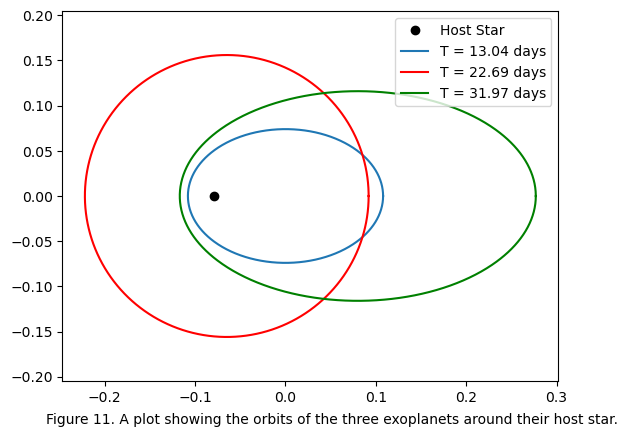

In [47]:
fig = plt.figure()
# Compute ellipse parameters
e = 0.729 #eccentricity
a = 0.108                             # Semimajor axis
x0 = 0                      # Center x-value
y0 = 0                     # Center y-value
b = 0.074              # Semiminor axis
phi = np.pi/2   # Angle betw major axis and x-axis

plt.plot(-1*a*e, 0, color = 'black', marker = 'o', label = 'Host Star', ls = 'None')

# Parametric plot in t
resolution = 1000
t = np.linspace(0, 2*np.pi, resolution)
y = x0 + a * np.cos(t) * np.cos(phi) - b * np.sin(t) * np.sin(phi)
x = y0 + a * np.cos(t) * np.sin(phi) + b * np.sin(t) * np.cos(phi)

# Plot ellipse
plt.plot(x, y, label = 'T = 13.04 days')


# Compute ellipse parameters
e = 0.086 #eccentricity
a = 0.157                           # Semimajor axis
x0 = 0                      # Center x-value
y0 = 0                     # Center y-value
b = 0.156              # Semiminor axis
phi = np.pi/2   # Angle betw major axis and x-axis

# Parametric plot in t
resolution = 1000
t = np.linspace(0, 2*np.pi, resolution)
y = x0 + a * np.cos(t) * np.cos(phi) - b * np.sin(t) * np.sin(phi)
x = y0 + a * np.cos(t) * np.sin(phi) + b * np.sin(t) * np.cos(phi)-0.065

# Plot ellipse
plt.plot(x, y, 'red', label = 'T = 22.69 days')


# Compute ellipse parameters
e = 0.807 #eccentricity
a = 0.197                           # Semimajor axis
x0 = 0                      # Center x-value
y0 = 0                     # Center y-value
b = 0.116              # Semiminor axis
phi = np.pi/2   # Angle betw major axis and x-axis

# Parametric plot in t
resolution = 1000
t = np.linspace(0, 2*np.pi, resolution)
y = x0 + a * np.cos(t) * np.cos(phi) - b * np.sin(t) * np.sin(phi)
x = y0 + a * np.cos(t) * np.sin(phi) + b * np.sin(t) * np.cos(phi)+0.08

# Plot ellipse
plt.plot(x, y, 'green', label = 'T = 31.97 days')


txt = '''Figure 11. A plot showing the orbits of the three exoplanets around their host star. '''
fig.text(.1,.02,txt)
plt.axis('equal')
plt.legend()
plt.show()

The high eccentricity seen in exoplanets 1 and 3 combined with the crossover of their orbits with that of exoplanet 2 is indicative of significant gravitational interactions between these three planets. Extreme gravitational interactions can cuase an exoplanet to move close enough to its host star to cross its Roche limit, resulting in it being torn apart by tidal forces. The Roche limit for Earth would be $0.007$AU, which is very similar to the Roche limit found for the three exoplanets.

The tidal locking zone for these exoplanets, $a_{TL} = 0.39 \pm 0.02$AU, was calculated by treating their host star as sun like. It is notable that all three exoplanets have semi major axes that place them within the tidal locking zone, meaning it is highly likely that they are tidally locked to their host star, or are in a resonant orbit. Mercury is an example of a planet with spin-orbit resonance, likely a result of it falling just outside the Sun's tidal locking zone, as it has a semi major axis of $0.4$AU. It has a 3:2 spin–orbit resonance, so it rotates on its axis three times for every two times it orbits around the sun. 

Transit timing variations arise from the gravitational interactions between exoplanets in a system. These variations have been used to discover exoplanets, and are particularly useful for lower mass exoplanets. However, they can introduce bias into determinations of eccentricity if not accounted for. 

As well as the aforementioned effects of transit timing variations, it is necessary to consider the effects of limb darkening on the transit lightcurve. This affects determinations of the ingress and egress time. Systematic biases are expected, as described by Seager and Mallen-Ornelas (2002), particularly in determining the radius of the exoplanet and the density of the host star. Further research into these effects and methods to account for this is necessary.

#### 3.3. Follow Up Observations

It is possible to determine the rotation period of exoplanets, and this has been done for the exoplanet Beta Pictoris b by Snellen et al (2014) through measuring the broadening of its carbon monoxide infrared absorption line. Applying similar methods to these exoplanets, dependent on their composition, should enable determination of their rotation period. For this to be possible, it would be necessary to obtain spectroscopic data of the exoplanets' composition to determine an appropriate molecule to apply this method to. With this information, it would be possible to deduce whether these exoplanets have spin-orbit resonance.

It would also be useful to make a better determination of the eccentricity of these exoplanets as transit timing variations are likely to have introduced bias into the values determined in this report. Due to time constraints, it was not possible to account for the bias introduced in this study, so further analysis into the eccentricity is necessary. It is possible to determine eccentricity from Kepler data, as done by Wei-Xie et al (2016), but this can also be done using radial velocity measurements, as demonstrated by Laughlin et al (2005).

### 4. Summary

$\bullet$ Three exoplanets were found by the transit method applied to data from the Kepler Space Telescope.

$\bullet$ Key parameters of these exoplanets were found, including their semi major axes and density:

In [48]:
#copy parameters table down
caption = "Table 4: Properties of the three exoplanets: Mass in Earth masses, Period in days, $\chi ^2$ from the transit model, and radius and density as calculated, and orbital properties: eccentricity and Roche limit"

df.style.pipe(make_pretty)

,Planet Name,Planet Mass / Earth masses,Period / days,$\chi ^2$,Semi Major Axis / AU,Radius / m,Density / gcm$^{-3}$,Eccentricity,Roche Limit / AU
0,Exoplanet 1,2.9 +2.9 -1.6,13.04 $\pm$ 0.05,3.03,0.12 $\pm$ 0.03,(23 $\pm$ 1) x 10$^6$,0.68 +0.68 -0.38,0.74 $\pm$ 0.04,0.009 +0.003 -0.0002
1,Exoplanet 2,7.3 +0.8 -1.5,22.69 $\pm$ 0.05,2.84,0.16 $\pm$ 0.03,(28 $\pm$ 1) x 10$^6$,0.93 +0.15 -0.22,0.26 $\pm$ 0.02,0.008 +0.0002 -0.002
2,Exoplanet 3,8.8 +1.5 -2.1,31.97 $\pm$ 0.05,3.41,0.20 $\pm$ 0.03,(30 $\pm$ 1) x 10$^6$,0.98 +0.19 -0.25,0.83 $\pm$ 0.05,0.008 +0.002 -0.003


$\bullet$ Kolmogorov–Smirnov testing showed it was highly likely the exoplanets found arise from the parent population: the NASA exoplanet archive.

$\bullet$ By comparing these exoplanets to other exoplanets in NASA's exoplanet archive in a mass-semi major axis plot, their formation mechanism was deduced. It was found that all three exoplanets most likely formed by core accretion.

$\bullet$ The photoeccentric effect was used to determine the orbital eccentricity of these exoplanets, and the high eccentricities found for two of them indicate significant interplanetary gravitational interactions.

$\bullet$ The Roche limit, at which point an exoplanet will be torn apart by tidal forces, was calculated for each exoplanet.

$\bullet$ It was found that all three exoplanets fall within their host star's tidal locking zone of $0.39 \pm 0.02$AU, and are therefore likely to have a synchronous orbit, or spin-orbit resonance.

$\bullet$ A useful follow up observation would be to determine the rotation period of these exoplanets to deduce whether or not they have spin-orbit resonance.

$\bullet$ It would be beneficial to further understand the effects of limb darkening on the modelling of the transit curve.

### References:
- Mayor & Queloz 1995, 'A Jupiter-mass companion to a solar-type star,' <i>Nature</i> 378, pp. 355–359. doi:10.1038/378355a0
- Mishra et al., 2023, 'Framework for the architecture of exoplanetary systems,' <i>A&A</i> 670, A68.
- Roche 1851, <i> Académie des sciences de Montpellier: Mémoires de la section des sciences. </i> 2. 
- Barnes 2017 'Tidal locking of habitable exoplanets,' <i>Celest Mech Dyn Astr</i> 129, pp. 509–536.
- VanderPlas, Jacob T 2018, 'Understanding the Lomb-Scargle Periodogram,' <i>The Astrophysical Journal Supplement Series</i> 236(1), id, 16
- Eylen & Albrecht 2015, 'Eccentricity from Transit Photometry: Small Planets in Kepler Multi-planet Systems Have Low Eccentricities,' <i>The Astrophysical Journal</i> 808, pp. 126
- Carter et al 2008, 'Analytic Approximations for Transit Light-Curve Observables, Uncertainties, and Covariances,' <i>The Astrophysical Journal</i>, 689, pp. 499-512.
- Ballesteros et al 2019, 'Diving into Exoplanets: Are Water Seas the Most Common?,' <i>Astrobiology</i> 19(5), pp. 642-654.
- Hasegawa & Pudritz 2013, 'Planetary Populations in the Mass-Period Diagram: A Statistical Treatment of Exoplanet Formation and the Role of Planet Traps,' <i>The Astrophysical Journal</i> 778(78) 16pp.
- D'Angelo et al 2010, 'Giant Planet Formation' in Seager's <i>Exoplanets</i> Tucson, AZ: University of Arizona Press, pp. 319-346.
- Kolmogorov–Smirnov test. Encyclopedia of Mathematics. URL: http://encyclopediaofmath.org/index.php?title=Kolmogorov%E2%80%93Smirnov_test&oldid=22660
- Snellen et al 2014, ' Fast spin of the young extrasolar planet β Pictoris b,' <i>Nature</i> 509(7498) pp. 63-65.
- Wei-Xie et al 2016, 'Exoplanet orbital eccentricities derived from LAMOST–Kepler analysis,' <i>PNAS</i> 113 (41) pp. 11431-11435.
- Laughlin 2005, 'On the Eccentricity of HD 209458b*,' <i>The Astrophysical Journal</i> 629(2) L121
- Seager & Mallen-Ornelas 2002, 'A Unique Solution of Planet and Star Parameters from an Extrasolar Planet Transit Light Curve,' <i>The Astrophysical Journal</i> 585 pp. 1038–1055.




### Acknowledgments
This research has made use of the NASA Exoplanet Archive, which is operated by the California Institute of Technology, under contract with the National Aeronautics and Space Administration under the Exoplanet Exploration Program.
